In [32]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.utils.vis_utils import plot_model
import functions
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle

import matplotlib.pyplot as plt
import librosa.display
import os.path
from shutil import copyfile

In [26]:
def mel_extract(file):
    y, sr = librosa.load(file, sr=None)
    duration = int(librosa.get_duration(filename=file))
    hop = int(sr*0.03)
    data = librosa.feature.melspectrogram(y=y[:(sr*duration-hop)], sr=sr, n_fft=int(sr*0.09), hop_length=hop)
    S_dB = librosa.power_to_db(data, ref=np.max)
    
    pickle_file1 = open(file[:-3] + 'pkl', 'wb')
    pickle.dump(data,pickle_file1)
    pickle_file1.close()
    
    pickle_file2 = open(file[:-3] + 'pkldb', 'wb')
    pickle.dump(S_dB,pickle_file2)
    pickle_file2.close()

In [36]:
# some mels were missing, fixing it w/ this
path = 'D:/dippa/voxceleb1/wav/'
training_filename = 'D:/dippa/speaker-verification/training_labels.lst'
training_list = open(training_filename, "r")
show_names, show_labels = functions.read_file(training_list)

for i, id in enumerate(show_names):
    if not os.path.isfile(path + id + '.pkl'):
        print(id)
        if not os.path.isfile(path + id + '.wav'):
            copyfile('E' + path[1:] + id + '.wav', path + id + '.wav')
            print('done')

        mel_extract(path + id + '.wav')

print('finished')

id11176/9HBSUu7-7v0/00026
finished


In [2]:
class opt:
    activation_function = 'relu'
    n_classes = 1211

In [4]:
def create_mlp(opt, dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    # return our model
    return model

def create_cnn(opt, n_blocks, n_filters, input_shape):
    print('.... Constructing CNN')
    init=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    inputs = Input(shape=(input_shape))

    if len(n_filters) < n_blocks:
       print('..... Define filter size for every CNN block')
    else:
       for i in range(n_blocks):
         name = ('block%d_conv_1'%(i+1))
         if i == 0:
            x = Conv2D(n_filters[i], kernel_size=(3,3), padding="same", activation=opt.activation_function, name=name)(inputs)
         else:
            x = Conv2D(n_filters[i], kernel_size=(3,3), padding="same", activation=opt.activation_function, name=name)(x)
         name = ('block%d_conv_2'%(i+1))
         x = Conv2D(n_filters[i], kernel_size=(3,3), padding="same", activation=opt.activation_function, name=name)(x)
         name = ('block%d_pool'%(i+1))
         x = MaxPooling2D(pool_size=(2,2), name=name)(x)
         
    x = Reshape((-1,(np.int(x.shape[2]*x.shape[3]))))(x)
    x = SeqWeightedAttention(name='attention_layer', return_attention=True)(x)
    x = Dense(1000, activation=opt.activation_function)(x[0])
    # x = Flatten()(x)
    # x = Dense(1000, activation=opt.activation_function)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(400, activation=opt.activation_function, name='Embedding')(x)
    x = Dense(opt.n_classes, activation='softmax', name='Classification')(x)
    model = Model(inputs, x)
    return model

In [4]:
input_shape1 = (150,9,1)
input_shape2 = (150,128,1)

# model = functions.create_cnn(opt, 3, n_filters=[128,256,512], input_shape=input_shape1)
model = functions.cnn_concat(opt, n_filters=[128,256,512], input_shape1=input_shape1, input_shape2=input_shape2)

model.summary()

.... Constructing CNN
.... Constructing CNN
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 9, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 150, 128, 1)  0                                            
__________________________________________________________________________________________________
block1_conv_1_mel (Conv2D)      (None, 150, 9, 128)  1280        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv_1_jit (Conv2D)      (None, 150, 128, 128 1280        input_2[0][0]                    
_________________________________________________________________

In [5]:
plot_model(model, to_file='concat.png', show_shapes=True, show_layer_names=True)

In [3]:
def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    # return our model
    return model

def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # flatten the volume, then FC => RELU => BN => DROPOUT
        x = Flatten()(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Dropout(0.5)(x)
        # apply another FC layer, this one to match the number of nodes
        # coming out of the MLP
        x = Dense(4)(x)
        x = Activation("relu")(x)
        # check to see if the regression node should be added
        if regress:
            x = Dense(1, activation="linear")(x)
        # construct the CNN
        model = Model(inputs, x)
        # return the CNN
        return model

In [10]:
mlp = create_mlp(10, regress=False)
cnn = create_cnn(64, 64, 3, regress=False)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

model.summary()
plot_model(model, to_file='asdf.png', show_shapes=True, show_layer_names=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 64, 64, 16)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 64, 64, 16)   64          activation_10[0][0]              
__________________________________________________________________________________________________
max_poolin

In [4]:
# generator byt anuj_shah

def DataGenerator(samples, path, batch_size=32,shuffle_data=True,window_size=100, suffix='.mel'):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        np.random.shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                file_name = batch_sample[0]
                label = batch_sample[1]
                
                with open(path + file_name + suffix, 'rb') as f:
                    f = functions.get_vector(np.transpose(pickle.load(f)), window_size, file_name)
                
                # apply any kind of preprocessing
                #img = cv2.resize(img,(resize,resize))
                # Add example to arrays
                X_train.append(f)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

In [21]:
# load data as list
training_filename = 'training_labels_test.lst'
path = 'D:/dippa/voxceleb1/vox1_test_wav/wav/'

training_list = open(training_filename, "r")
# return list of names and a list of labels
show_names, show_labels = functions.read_file(training_list)

# To encode target labels with value between 0 and n_classes-1
label_encoder = LabelEncoder()
data_labels = label_encoder.fit_transform(show_labels)
n_classes = len(np.unique(data_labels))
print('Number of classes',len(np.unique(data_labels)))

samples = []
for name,label in zip(show_names,data_labels):
    samples.append([name,label])
    
# Partitions train 80%, validation 20%
train_names, val_names = train_test_split(samples, test_size=0.20, random_state=4)
partition = {'train':train_names, 'validation':val_names}

# Parameters
params = {'batch_size': 32,
                    'shuffle_data': True,
                    'window_size': 100,
                    'suffix': '.pkl'}
# Generators
training_generator = DataGenerator(partition['train'], path, **params)
validation_generator = DataGenerator(partition['validation'], path, **params)


Number of classes 40


In [22]:
batch = next(training_generator)
b = batch[0][0].reshape((100,128))

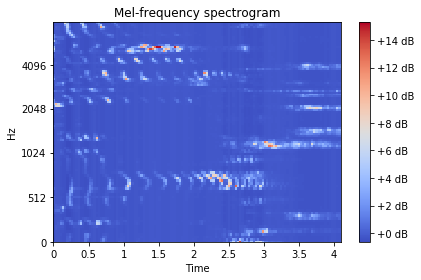

In [25]:
# plot one spectrogram
Sb = b
librosa.display.specshow(Sb, x_axis='time', y_axis='mel', sr=16000, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

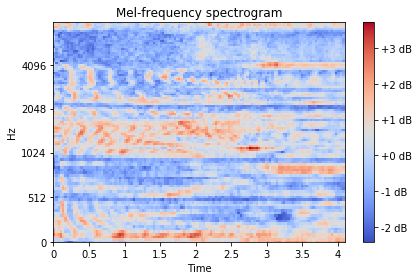

In [20]:
librosa.display.specshow(Sb, x_axis='time', y_axis='mel', sr=16000, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()